In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader

In [3]:
#导入train数据
a=np.load("train_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
train_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("train_label.npy").reshape(-1,1)
train_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [7]:
#导入valid数据
a=np.load("valid_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
valid_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("valid_label.npy").reshape(-1,1)
valid_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [77]:
def predict_precision(model,images,labels,device,predict_type):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return predicted, 100*correct/total

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [18]:
#LSTM trial 1
#Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 64  # 隐藏层的size
num_layers =  2 # 有多少层

num_classes = 2
batch_size = 512
num_epochs = 800
learning_rate = 0.01

device = torch.device("cuda:1")

In [41]:
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [20]:
lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
lstm.to(device)

LSTM(
  (lstm): LSTM(42, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [22]:
total_step=0
train_precision=[]
valid_precision=[]

In [23]:
#训练过程
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:#each 10 iterations is one epoch
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [12/800],step[1000] Loss:0.6002
precision of the model on thetrainingdata: 59.03083801269531%
precision of the model on thevalidationdata: 55.36198043823242%
Epoch [24/800],step[2000] Loss:0.5610
precision of the model on thetrainingdata: 67.123291015625%
precision of the model on thevalidationdata: 52.74390411376953%
Epoch [36/800],step[3000] Loss:0.5899
precision of the model on thetrainingdata: 59.75609588623047%
precision of the model on thevalidationdata: 56.1228141784668%
Epoch [48/800],step[4000] Loss:0.5811
precision of the model on thetrainingdata: 67.00507354736328%
precision of the model on thevalidationdata: 56.38418197631836%
Epoch [60/800],step[5000] Loss:0.5567
precision of the model on thetrainingdata: 66.35944366455078%
precision of the model on thevalidationdata: 56.25324249267578%
Epoch [72/800],step[6000] Loss:0.4975
precision of the model on thetrainingdata: 78.04878234863281%
precision of the model on thevalidationdata: 55.18610382080078%
Epoch [84/800],step

Epoch [608/800],step[51000] Loss:0.3282
precision of the model on thetrainingdata: 87.28070068359375%
precision of the model on thevalidationdata: 54.286617279052734%
Epoch [620/800],step[52000] Loss:0.3374
precision of the model on thetrainingdata: 85.1351318359375%
precision of the model on thevalidationdata: 54.57227325439453%
Epoch [631/800],step[53000] Loss:0.3263
precision of the model on thetrainingdata: 86.36363983154297%
precision of the model on thevalidationdata: 54.215370178222656%
Epoch [643/800],step[54000] Loss:0.3265
precision of the model on thetrainingdata: 86.00823211669922%
precision of the model on thevalidationdata: 54.050010681152344%
Epoch [655/800],step[55000] Loss:0.3753
precision of the model on thetrainingdata: 81.56681823730469%
precision of the model on thevalidationdata: 53.410152435302734%
Epoch [667/800],step[56000] Loss:0.3756
precision of the model on thetrainingdata: 84.03755950927734%
precision of the model on thevalidationdata: 55.62130355834961%
E

Text(0, 0.5, 'precision')

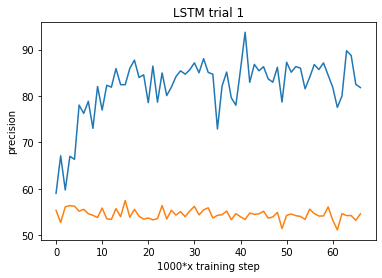

In [24]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("LSTM trial 1")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [25]:
#trial 1 结果分析：
#随着训练步数的增加模型loss无法继续收敛，可能是由于梯度消失。
#下一步，增加num_epochs并缩小learning_rate和batch_size

In [30]:
#LSTM trial 2
#Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 64  # 隐藏层的size
num_layers =  2 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 1200
learning_rate = 0.001

device = torch.device("cuda:1")

In [31]:
lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
lstm.to(device)

LSTM(
  (lstm): LSTM(42, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [33]:
total_step=0
train_precision=[]
valid_precision=[]

In [101]:
#训练过程
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:#each 10 iterations is one epoch
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [2/200],step[1000] Loss:0.6553
precision of the model on thetrainingdata: 57.0%
precision of the model on thevalidationdata: 44.776119232177734%
Epoch [8/200],step[2000] Loss:0.6334
precision of the model on thetrainingdata: 59.0476188659668%
precision of the model on thevalidationdata: 48.53009796142578%
Epoch [14/200],step[3000] Loss:0.6293
precision of the model on thetrainingdata: 58.620689392089844%
precision of the model on thevalidationdata: 50.94581604003906%
Epoch [20/200],step[4000] Loss:0.6273
precision of the model on thetrainingdata: 64.16666412353516%
precision of the model on thevalidationdata: 48.84507751464844%
Epoch [26/200],step[5000] Loss:0.5817
precision of the model on thetrainingdata: 66.91728973388672%
precision of the model on thevalidationdata: 48.43913269042969%


KeyboardInterrupt: 

Text(0, 0.5, 'precision')

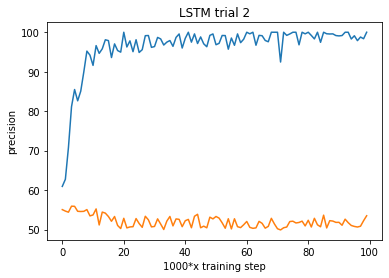

In [35]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("LSTM trial 2")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [36]:
#trial 2 结果分析：
#上述提出的解决训练过程中梯度爆炸问题的方法是有效的，训练集已经可以达到接近100%的预测准确率
#但是在valid_data中很早就到达了过拟合点（12000 steps 左右），valid precision在0.54-0.56左右
#故认为在2层hidden layer LSTM下，此precision范围已经是极限，下面需要尝试其他hidden layer层数的LSTM
#batch_size 和 learning_rate 在接下来的实验中不变

Epoch [6/1000],step[1000] Loss:0.6330
precision of the model on thetrainingdata: 55.64516067504883%
precision of the model on thevalidationdata: 55.306427001953125%
Epoch [12/1000],step[2000] Loss:0.5659
precision of the model on thetrainingdata: 66.07142639160156%
precision of the model on thevalidationdata: 55.51384353637695%
Epoch [18/1000],step[3000] Loss:0.5406
precision of the model on thetrainingdata: 73.28244018554688%
precision of the model on thevalidationdata: 54.909420013427734%
Epoch [24/1000],step[4000] Loss:0.5868
precision of the model on thetrainingdata: 58.730159759521484%
precision of the model on thevalidationdata: 52.10544204711914%
Epoch [30/1000],step[5000] Loss:0.5147
precision of the model on thetrainingdata: 73.07691955566406%
precision of the model on thevalidationdata: 57.498714447021484%
Epoch [36/1000],step[6000] Loss:0.4245
precision of the model on thetrainingdata: 84.07079315185547%
precision of the model on thevalidationdata: 57.27988052368164%
Epoch [

precision of the model on thevalidationdata: 52.950496673583984%
Epoch [306/1000],step[51000] Loss:0.0447
precision of the model on thetrainingdata: 98.52941131591797%
precision of the model on thevalidationdata: 53.07989501953125%
Epoch [312/1000],step[52000] Loss:0.0952
precision of the model on thetrainingdata: 98.29059600830078%
precision of the model on thevalidationdata: 52.650821685791016%
Epoch [318/1000],step[53000] Loss:0.0555
precision of the model on thetrainingdata: 99.17355346679688%
precision of the model on thevalidationdata: 53.01998519897461%
Epoch [324/1000],step[54000] Loss:0.0485
precision of the model on thetrainingdata: 98.31932830810547%
precision of the model on thevalidationdata: 52.93906021118164%
Epoch [330/1000],step[55000] Loss:0.0809
precision of the model on thetrainingdata: 97.2727279663086%
precision of the model on thevalidationdata: 53.1357536315918%
Epoch [336/1000],step[56000] Loss:0.0285
precision of the model on thetrainingdata: 99.05660247802734

precision of the model on thevalidationdata: 53.46328353881836%
Epoch [605/1000],step[101000] Loss:0.0252
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.60550308227539%
Epoch [611/1000],step[102000] Loss:0.0436
precision of the model on thetrainingdata: 98.1651382446289%
precision of the model on thevalidationdata: 52.96490478515625%
Epoch [617/1000],step[103000] Loss:0.0263
precision of the model on thetrainingdata: 97.65625%
precision of the model on thevalidationdata: 50.27180480957031%
Epoch [623/1000],step[104000] Loss:0.0367
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.1466178894043%
Epoch [629/1000],step[105000] Loss:0.0314
precision of the model on thetrainingdata: 98.36065673828125%
precision of the model on thevalidationdata: 52.59109878540039%
Epoch [635/1000],step[106000] Loss:0.0282
precision of the model on thetrainingdata: 98.24561309814453%
precision of the model on t

Epoch [905/1000],step[151000] Loss:0.0220
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.637245178222656%
Epoch [911/1000],step[152000] Loss:0.1148
precision of the model on thetrainingdata: 98.4251937866211%
precision of the model on thevalidationdata: 51.219818115234375%
Epoch [917/1000],step[153000] Loss:0.0141
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.52117156982422%
Epoch [923/1000],step[154000] Loss:0.0127
precision of the model on thetrainingdata: 99.15966033935547%
precision of the model on thevalidationdata: 52.63883972167969%
Epoch [929/1000],step[155000] Loss:0.0169
precision of the model on thetrainingdata: 99.13793182373047%
precision of the model on thevalidationdata: 50.523170471191406%
Epoch [935/1000],step[156000] Loss:0.0465
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 50.230770111083984%
Epoch [941/1000],step[157

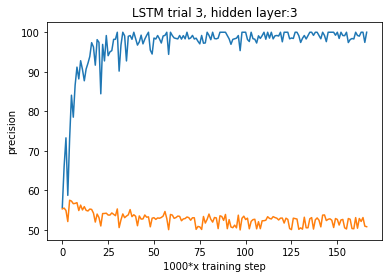

Epoch [6/1000],step[1000] Loss:0.5777
precision of the model on thetrainingdata: 62.16216278076172%
precision of the model on thevalidationdata: 55.801944732666016%
Epoch [12/1000],step[2000] Loss:0.6114
precision of the model on thetrainingdata: 66.17646789550781%
precision of the model on thevalidationdata: 51.67349624633789%
Epoch [18/1000],step[3000] Loss:0.5694
precision of the model on thetrainingdata: 57.894737243652344%
precision of the model on thevalidationdata: 57.566001892089844%
Epoch [24/1000],step[4000] Loss:0.5256
precision of the model on thetrainingdata: 68.86792755126953%
precision of the model on thevalidationdata: 56.62313461303711%
Epoch [30/1000],step[5000] Loss:0.5059
precision of the model on thetrainingdata: 75.49019622802734%
precision of the model on thevalidationdata: 56.696876525878906%
Epoch [36/1000],step[6000] Loss:0.4591
precision of the model on thetrainingdata: 78.46154022216797%
precision of the model on thevalidationdata: 57.01873016357422%
Epoch [

Epoch [306/1000],step[51000] Loss:0.0414
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.01433563232422%
Epoch [312/1000],step[52000] Loss:0.0407
precision of the model on thetrainingdata: 98.4251937866211%
precision of the model on thevalidationdata: 51.47929000854492%
Epoch [318/1000],step[53000] Loss:0.0618
precision of the model on thetrainingdata: 99.1869888305664%
precision of the model on thevalidationdata: 53.70191192626953%
Epoch [324/1000],step[54000] Loss:0.0218
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.563838958740234%
Epoch [330/1000],step[55000] Loss:0.1406
precision of the model on thetrainingdata: 98.26087188720703%
precision of the model on thevalidationdata: 52.47050094604492%
Epoch [336/1000],step[56000] Loss:0.0191
precision of the model on thetrainingdata: 99.22480773925781%
precision of the model on thevalidationdata: 53.440452575683594%
Epoch [342/1000],step[

precision of the model on thevalidationdata: 50.619625091552734%
Epoch [611/1000],step[102000] Loss:0.0272
precision of the model on thetrainingdata: 99.24242401123047%
precision of the model on thevalidationdata: 52.64161682128906%
Epoch [617/1000],step[103000] Loss:0.1344
precision of the model on thetrainingdata: 95.37036895751953%
precision of the model on thevalidationdata: 50.677371978759766%
Epoch [623/1000],step[104000] Loss:0.0162
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.53532791137695%
Epoch [629/1000],step[105000] Loss:0.1205
precision of the model on thetrainingdata: 97.6377944946289%
precision of the model on thevalidationdata: 52.99873352050781%
Epoch [635/1000],step[106000] Loss:0.0172
precision of the model on thetrainingdata: 98.44961547851562%
precision of the model on thevalidationdata: 50.63654708862305%
Epoch [641/1000],step[107000] Loss:0.1040
precision of the model on thetrainingdata: 98.4962387084961%
prec

precision of the model on thevalidationdata: 54.15142822265625%
Epoch [917/1000],step[153000] Loss:0.0125
precision of the model on thetrainingdata: 98.4126968383789%
precision of the model on thevalidationdata: 51.17182159423828%
Epoch [923/1000],step[154000] Loss:0.1099
precision of the model on thetrainingdata: 97.2477035522461%
precision of the model on thevalidationdata: 52.94215774536133%
Epoch [929/1000],step[155000] Loss:0.0135
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.762969970703125%
Epoch [935/1000],step[156000] Loss:0.0264
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.658565521240234%
Epoch [941/1000],step[157000] Loss:0.0131
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.80434799194336%
Epoch [947/1000],step[158000] Loss:0.0163
precision of the model on thetrainingdata: 99.11504364013672%
precision of the model on th

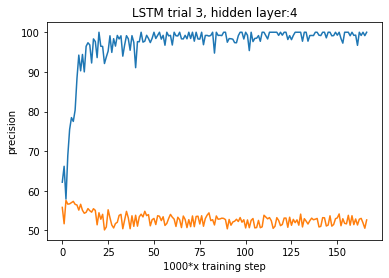

Epoch [6/1000],step[1000] Loss:0.6204
precision of the model on thetrainingdata: 57.14285659790039%
precision of the model on thevalidationdata: 55.76271057128906%
Epoch [12/1000],step[2000] Loss:0.5740
precision of the model on thetrainingdata: 72.34042358398438%
precision of the model on thevalidationdata: 57.131080627441406%
Epoch [18/1000],step[3000] Loss:0.5670
precision of the model on thetrainingdata: 73.27586364746094%
precision of the model on thevalidationdata: 58.22147750854492%
Epoch [24/1000],step[4000] Loss:0.5636
precision of the model on thetrainingdata: 68.86792755126953%
precision of the model on thevalidationdata: 57.83783721923828%
Epoch [30/1000],step[5000] Loss:0.5446
precision of the model on thetrainingdata: 77.19298553466797%
precision of the model on thevalidationdata: 56.469139099121094%
Epoch [36/1000],step[6000] Loss:0.4956
precision of the model on thetrainingdata: 74.10713958740234%
precision of the model on thevalidationdata: 54.633148193359375%
Epoch [4

Epoch [306/1000],step[51000] Loss:0.0387
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.75342559814453%
Epoch [312/1000],step[52000] Loss:0.0282
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.926239013671875%
Epoch [318/1000],step[53000] Loss:0.0333
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.743316650390625%
Epoch [324/1000],step[54000] Loss:0.0599
precision of the model on thetrainingdata: 97.34513092041016%
precision of the model on thevalidationdata: 51.14667510986328%
Epoch [330/1000],step[55000] Loss:0.0315
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 54.03919982910156%
Epoch [336/1000],step[56000] Loss:0.0496
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.73163604736328%
Epoch [342/1000],step[57000] Loss:0.0615
precision of th

Epoch [611/1000],step[102000] Loss:0.0285
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.995304107666016%
Epoch [617/1000],step[103000] Loss:0.0237
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.665740966796875%
Epoch [623/1000],step[104000] Loss:0.0283
precision of the model on thetrainingdata: 99.20635223388672%
precision of the model on thevalidationdata: 54.37477111816406%
Epoch [629/1000],step[105000] Loss:0.0148
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.42239761352539%
Epoch [635/1000],step[106000] Loss:0.0748
precision of the model on thetrainingdata: 98.4962387084961%
precision of the model on thevalidationdata: 51.90995788574219%
Epoch [641/1000],step[107000] Loss:0.0142
precision of the model on thetrainingdata: 97.58064270019531%
precision of the model on thevalidationdata: 52.69077682495117%
Epoch [647/1000],step[10800

precision of the model on thevalidationdata: 51.631126403808594%
Epoch [923/1000],step[154000] Loss:0.0280
precision of the model on thetrainingdata: 99.19999694824219%
precision of the model on thevalidationdata: 51.63168716430664%
Epoch [929/1000],step[155000] Loss:0.0026
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.55648422241211%
Epoch [935/1000],step[156000] Loss:0.0084
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.945335388183594%
Epoch [941/1000],step[157000] Loss:0.0254
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.240962982177734%
Epoch [947/1000],step[158000] Loss:0.0678
precision of the model on thetrainingdata: 97.58064270019531%
precision of the model on thevalidationdata: 53.65654754638672%
Epoch [953/1000],step[159000] Loss:0.0147
precision of the model on thetrainingdata: 99.15966033935547%
precision of the model on

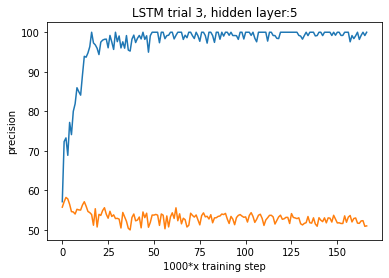

Epoch [6/1000],step[1000] Loss:0.5922
precision of the model on thetrainingdata: 61.71875%
precision of the model on thevalidationdata: 55.29521942138672%
Epoch [12/1000],step[2000] Loss:0.5900
precision of the model on thetrainingdata: 70.68965148925781%
precision of the model on thevalidationdata: 56.81440353393555%
Epoch [18/1000],step[3000] Loss:0.6113
precision of the model on thetrainingdata: 66.93548583984375%
precision of the model on thevalidationdata: 57.87234115600586%
Epoch [24/1000],step[4000] Loss:0.5855
precision of the model on thetrainingdata: 62.83185958862305%
precision of the model on thevalidationdata: 55.75949478149414%
Epoch [30/1000],step[5000] Loss:0.5710
precision of the model on thetrainingdata: 75.19380187988281%
precision of the model on thevalidationdata: 55.729984283447266%
Epoch [36/1000],step[6000] Loss:0.4818
precision of the model on thetrainingdata: 74.13793182373047%
precision of the model on thevalidationdata: 57.01936340332031%
Epoch [42/1000],ste

precision of the model on thevalidationdata: 54.836570739746094%
Epoch [306/1000],step[51000] Loss:0.0806
precision of the model on thetrainingdata: 98.27586364746094%
precision of the model on thevalidationdata: 53.735103607177734%
Epoch [312/1000],step[52000] Loss:0.0548
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.41139221191406%
Epoch [318/1000],step[53000] Loss:0.0795
precision of the model on thetrainingdata: 98.0952377319336%
precision of the model on thevalidationdata: 54.42340087890625%
Epoch [324/1000],step[54000] Loss:0.0733
precision of the model on thetrainingdata: 98.18181610107422%
precision of the model on thevalidationdata: 54.117164611816406%
Epoch [330/1000],step[55000] Loss:0.1010
precision of the model on thetrainingdata: 97.54098510742188%
precision of the model on thevalidationdata: 55.07890701293945%
Epoch [336/1000],step[56000] Loss:0.0437
precision of the model on thetrainingdata: 96.74797058105469%
precisio

precision of the model on thevalidationdata: 50.73139953613281%
Epoch [605/1000],step[101000] Loss:0.0449
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 54.13060760498047%
Epoch [611/1000],step[102000] Loss:0.0280
precision of the model on thetrainingdata: 97.5999984741211%
precision of the model on thevalidationdata: 50.61406707763672%
Epoch [617/1000],step[103000] Loss:0.0491
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 54.32309341430664%
Epoch [623/1000],step[104000] Loss:0.0256
precision of the model on thetrainingdata: 96.89922332763672%
precision of the model on thevalidationdata: 50.990989685058594%
Epoch [629/1000],step[105000] Loss:0.0792
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 54.29656219482422%
Epoch [635/1000],step[106000] Loss:0.0187
precision of the model on thetrainingdata: 99.23076629638672%
precision of the model on th

Epoch [905/1000],step[151000] Loss:0.0261
precision of the model on thetrainingdata: 99.15254211425781%
precision of the model on thevalidationdata: 53.29795455932617%
Epoch [911/1000],step[152000] Loss:0.0284
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.0958137512207%
Epoch [917/1000],step[153000] Loss:0.0150
precision of the model on thetrainingdata: 99.1869888305664%
precision of the model on thevalidationdata: 53.259220123291016%
Epoch [923/1000],step[154000] Loss:0.0296
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.190738677978516%
Epoch [929/1000],step[155000] Loss:0.0125
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.353179931640625%
Epoch [935/1000],step[156000] Loss:0.0248
precision of the model on thetrainingdata: 97.45762634277344%
precision of the model on thevalidationdata: 50.8143310546875%
Epoch [941/1000],step[157000

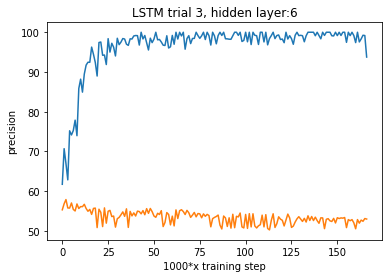

In [59]:
#LSTM trial 3
for i in range(3,7):
    #Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    input_size = 42  # 输入数据的维度
    hidden_size = 64  # 隐藏层的size
    num_layers =  i # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 1000
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("LSTM trial 3, hidden layer:"+str(i))
    plt.xlabel("1000*x training step")
    plt.ylabel("precision")
    plt.show()

In [60]:
#trial 3 结果分析:
#增加layer层数最终的valid precision并没有太大变化，过拟合前集中在0.555-0.575（略好于2layer结构？）
#下一步尝试：增加l2 penalty

Epoch [6/800],step[1000] Loss:0.6092
precision of the model on thetrainingdata: 64.83516693115234%
precision of the model on thevalidationdata: 55.83333206176758%
Epoch [12/800],step[2000] Loss:0.5545
precision of the model on thetrainingdata: 56.25%
precision of the model on thevalidationdata: 54.22063446044922%
Epoch [18/800],step[3000] Loss:0.5952
precision of the model on thetrainingdata: 68.0%
precision of the model on thevalidationdata: 57.61421203613281%
Epoch [24/800],step[4000] Loss:0.5920
precision of the model on thetrainingdata: 66.15384674072266%
precision of the model on thevalidationdata: 54.98095703125%
Epoch [30/800],step[5000] Loss:0.5787
precision of the model on thetrainingdata: 75.4385986328125%
precision of the model on thevalidationdata: 54.70265579223633%
Epoch [36/800],step[6000] Loss:0.5741
precision of the model on thetrainingdata: 69.29133605957031%
precision of the model on thevalidationdata: 55.69328308105469%
Epoch [42/800],step[7000] Loss:0.5104
precisio

Epoch [306/800],step[51000] Loss:0.1041
precision of the model on thetrainingdata: 93.91304016113281%
precision of the model on thevalidationdata: 49.26416015625%
Epoch [312/800],step[52000] Loss:0.1206
precision of the model on thetrainingdata: 95.04132080078125%
precision of the model on thevalidationdata: 51.28205108642578%
Epoch [318/800],step[53000] Loss:0.1042
precision of the model on thetrainingdata: 99.03845977783203%
precision of the model on thevalidationdata: 53.11720657348633%
Epoch [324/800],step[54000] Loss:0.1079
precision of the model on thetrainingdata: 99.06542205810547%
precision of the model on thevalidationdata: 53.74345397949219%
Epoch [330/800],step[55000] Loss:0.0906
precision of the model on thetrainingdata: 98.18181610107422%
precision of the model on thevalidationdata: 53.95442199707031%
Epoch [336/800],step[56000] Loss:0.0735
precision of the model on thetrainingdata: 96.06299591064453%
precision of the model on thevalidationdata: 51.194786071777344%
Epoch 

Epoch [605/800],step[101000] Loss:0.0902
precision of the model on thetrainingdata: 97.47898864746094%
precision of the model on thevalidationdata: 53.5722541809082%
Epoch [611/800],step[102000] Loss:0.0489
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 54.079551696777344%
Epoch [617/800],step[103000] Loss:0.0864
precision of the model on thetrainingdata: 97.93814086914062%
precision of the model on thevalidationdata: 53.298011779785156%
Epoch [623/800],step[104000] Loss:0.0890
precision of the model on thetrainingdata: 99.17355346679688%
precision of the model on thevalidationdata: 53.940940856933594%
Epoch [629/800],step[105000] Loss:0.0753
precision of the model on thetrainingdata: 97.19625854492188%
precision of the model on thevalidationdata: 54.471954345703125%
Epoch [635/800],step[106000] Loss:0.0601
precision of the model on thetrainingdata: 97.7272720336914%
precision of the model on thevalidationdata: 53.50267791748047%
Epoch [6

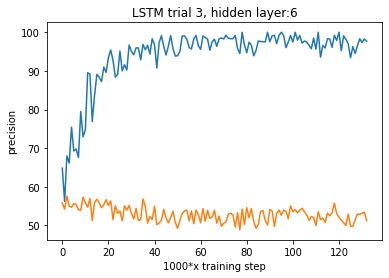

In [66]:
#LSTM trial 4
#Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 64  # 隐藏层的size
num_layers =  4 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 800
learning_rate = 0.001

device = torch.device("cuda:1")
    
lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
lstm.to(device)
    
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.0001)
    
total_step=0
train_precision=[]
valid_precision=[]
    
#训练过程
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:#each 10 iterations is one epoch
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)
            
#plot
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("LSTM trial 3, hidden layer:"+str(i))
plt.xlabel("1000*x training step")
plt.ylabel("precision")
plt.show()

In [67]:
#trial 4 结果分析: L2 penalty 无效
#下一步尝试：加drop out

In [80]:
#trial 5 使用dropout LSTM：
class DropOut_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(DropOut_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.drop = nn.Dropout(0.65)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)
        
        out = self.drop(out)
        
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

Epoch [6/800],step[1000] Loss:0.6135
precision of the model on thetrainingdata: 59.09090805053711%
precision of the model on thevalidationdata: 59.5971565246582%
Epoch [12/800],step[2000] Loss:0.6031
precision of the model on thetrainingdata: 72.80000305175781%
precision of the model on thevalidationdata: 56.916996002197266%
Epoch [18/800],step[3000] Loss:0.5271
precision of the model on thetrainingdata: 67.01030731201172%
precision of the model on thevalidationdata: 57.808109283447266%
Epoch [24/800],step[4000] Loss:0.4936
precision of the model on thetrainingdata: 71.42857360839844%
precision of the model on thevalidationdata: 56.741573333740234%
Epoch [30/800],step[5000] Loss:0.4187
precision of the model on thetrainingdata: 79.79798126220703%
precision of the model on thevalidationdata: 56.62285232543945%
Epoch [36/800],step[6000] Loss:0.2295
precision of the model on thetrainingdata: 89.43089294433594%
precision of the model on thevalidationdata: 54.83165740966797%
Epoch [42/800],

Epoch [312/800],step[52000] Loss:0.0111
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.72398376464844%
Epoch [318/800],step[53000] Loss:0.0173
precision of the model on thetrainingdata: 99.09091186523438%
precision of the model on thevalidationdata: 53.385826110839844%
Epoch [324/800],step[54000] Loss:0.0149
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.297183990478516%
Epoch [330/800],step[55000] Loss:0.1013
precision of the model on thetrainingdata: 99.19355010986328%
precision of the model on thevalidationdata: 53.841796875%
Epoch [336/800],step[56000] Loss:0.0319
precision of the model on thetrainingdata: 99.25373077392578%
precision of the model on thevalidationdata: 54.410987854003906%
Epoch [342/800],step[57000] Loss:0.0180
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.00065994262695%
Epoch [348/800],step[58000] Loss:0.0383
pr

Epoch [623/800],step[104000] Loss:0.0113
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 51.95500946044922%
Epoch [629/800],step[105000] Loss:0.0384
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.742332458496094%
Epoch [635/800],step[106000] Loss:0.0263
precision of the model on thetrainingdata: 99.17355346679688%
precision of the model on thevalidationdata: 53.07380676269531%
Epoch [641/800],step[107000] Loss:0.0281
precision of the model on thetrainingdata: 99.1869888305664%
precision of the model on thevalidationdata: 52.66153335571289%
Epoch [647/800],step[108000] Loss:0.0211
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.26743698120117%
Epoch [653/800],step[109000] Loss:0.0180
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 53.44169998168945%
Epoch [659/800],step[110000] Loss:0.0181
preci

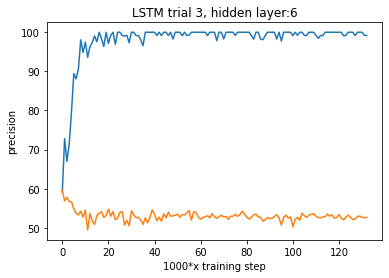

In [81]:
#Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 128  # 隐藏层的size
num_layers =  4 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 800
learning_rate = 0.001

device = torch.device("cuda:1")
    
lstm = DropOut_LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
lstm.to(device)
    
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    
total_step=0
train_precision=[]
valid_precision=[]
    
#训练过程
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:#each 10 iterations is one epoch
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)
            
#plot
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("LSTM trial 3, hidden layer:"+str(i))
plt.xlabel("1000*x training step")
plt.ylabel("precision")
plt.show()

In [83]:
#trial 4 结果分析: dropout 无效
#下一步试验：缩减factor数

In [88]:
#trial 5 缩减factor数至：4

In [100]:

rand_select=[]
max_precision=[]
for i in range(20):
    factor=np.random.randint(42, size=4)
    rand_select.append(factor)
    train_temp=train_data[:,:,factor]
    valid_temp=valid_data[:,:,factor]
    train=GetLoader(train_temp,train_label)
    valid=GetLoader(valid_temp,valid_label)
    
    #Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    input_size = 4  # 输入数据的维度
    hidden_size = 64  # 隐藏层的size
    num_layers =  3 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 200
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
    valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)
    
    lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
    
    max_precision.append(max(valid_precision))
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("LSTM trial 5, hidden layer:"+str(i))
    plt.xlabel("1000*x training step")
    plt.ylabel("precision")
    plt.show()

Epoch [1/200],step[100] Loss:0.6931
precision of the model on thetrainingdata: nan%
precision of the model on thevalidationdata: nan%
Epoch [2/200],step[200] Loss:0.6929
precision of the model on thetrainingdata: 50.0%
precision of the model on thevalidationdata: 70.12986755371094%
Epoch [2/200],step[300] Loss:0.6856
precision of the model on thetrainingdata: nan%
precision of the model on thevalidationdata: nan%
Epoch [3/200],step[400] Loss:0.7041
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 71.64179229736328%
Epoch [3/200],step[500] Loss:0.6940
precision of the model on thetrainingdata: 55.04587173461914%
precision of the model on thevalidationdata: 54.91698455810547%
Epoch [4/200],step[600] Loss:0.6939
precision of the model on thetrainingdata: 46.83544158935547%
precision of the model on thevalidationdata: 60.682491302490234%
Epoch [5/200],step[700] Loss:0.6908
precision of the model on thetrainingdata: 55.20833206176758%
precision 

KeyboardInterrupt: 

In [93]:
max_precision[18]

tensor(57.9623, device='cuda:1')

In [94]:
#trial 5 结果分析: 无效
#下一步试验：随机组合成10个factor

Epoch [6/150],step[1000] Loss:0.6294
precision of the model on thetrainingdata: 53.703704833984375%
precision of the model on thevalidationdata: 54.8399543762207%
Epoch [12/150],step[2000] Loss:0.6006
precision of the model on thetrainingdata: 65.81196594238281%
precision of the model on thevalidationdata: 55.43925094604492%
Epoch [18/150],step[3000] Loss:0.6004
precision of the model on thetrainingdata: 65.55555725097656%
precision of the model on thevalidationdata: 54.0864143371582%
Epoch [24/150],step[4000] Loss:0.5971
precision of the model on thetrainingdata: 63.35877990722656%
precision of the model on thevalidationdata: 51.72750473022461%
Epoch [30/150],step[5000] Loss:0.5502
precision of the model on thetrainingdata: 67.2131118774414%
precision of the model on thevalidationdata: 54.55330276489258%
Epoch [36/150],step[6000] Loss:0.5435
precision of the model on thetrainingdata: 69.3548355102539%
precision of the model on thevalidationdata: 52.63642501831055%
Epoch [42/150],step[

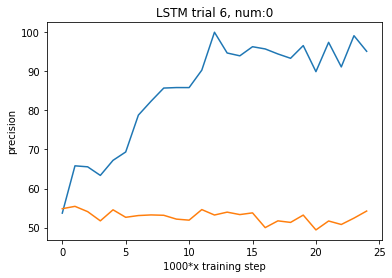

Epoch [6/150],step[1000] Loss:0.6878
precision of the model on thetrainingdata: 58.82352828979492%
precision of the model on thevalidationdata: 59.66069793701172%
Epoch [12/150],step[2000] Loss:0.6142
precision of the model on thetrainingdata: 61.403507232666016%
precision of the model on thevalidationdata: 49.55651092529297%
Epoch [18/150],step[3000] Loss:0.5871
precision of the model on thetrainingdata: 62.068965911865234%
precision of the model on thevalidationdata: 52.26609420776367%
Epoch [24/150],step[4000] Loss:0.5484
precision of the model on thetrainingdata: 62.295082092285156%
precision of the model on thevalidationdata: 49.37452697753906%
Epoch [30/150],step[5000] Loss:0.5152
precision of the model on thetrainingdata: 71.96969604492188%
precision of the model on thevalidationdata: 50.618892669677734%
Epoch [36/150],step[6000] Loss:0.4982
precision of the model on thetrainingdata: 71.31147766113281%
precision of the model on thevalidationdata: 50.01026153564453%
Epoch [42/150

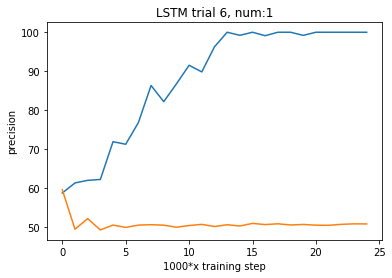

Epoch [6/150],step[1000] Loss:0.6488
precision of the model on thetrainingdata: 64.81481170654297%
precision of the model on thevalidationdata: 47.87677001953125%
Epoch [12/150],step[2000] Loss:0.5835
precision of the model on thetrainingdata: 66.34615325927734%
precision of the model on thevalidationdata: 50.51792907714844%
Epoch [18/150],step[3000] Loss:0.6357
precision of the model on thetrainingdata: 59.8425178527832%
precision of the model on thevalidationdata: 52.43150329589844%
Epoch [24/150],step[4000] Loss:0.5895
precision of the model on thetrainingdata: 68.31683349609375%
precision of the model on thevalidationdata: 53.25919723510742%
Epoch [30/150],step[5000] Loss:0.5832
precision of the model on thetrainingdata: 65.74073791503906%
precision of the model on thevalidationdata: 52.78202438354492%
Epoch [36/150],step[6000] Loss:0.5514
precision of the model on thetrainingdata: 69.56521606445312%
precision of the model on thevalidationdata: 52.66145324707031%
Epoch [42/150],ste

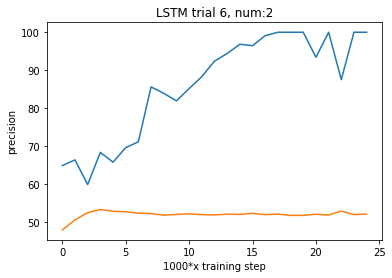

Epoch [6/150],step[1000] Loss:0.5831
precision of the model on thetrainingdata: 70.27027130126953%
precision of the model on thevalidationdata: 49.315067291259766%
Epoch [12/150],step[2000] Loss:0.6266
precision of the model on thetrainingdata: 52.8301887512207%
precision of the model on thevalidationdata: 56.84702682495117%
Epoch [18/150],step[3000] Loss:0.6386
precision of the model on thetrainingdata: 68.96551513671875%
precision of the model on thevalidationdata: 52.071006774902344%
Epoch [24/150],step[4000] Loss:0.5954
precision of the model on thetrainingdata: 66.10169219970703%
precision of the model on thevalidationdata: 49.35175323486328%
Epoch [30/150],step[5000] Loss:0.5636
precision of the model on thetrainingdata: 68.14814758300781%
precision of the model on thevalidationdata: 52.237545013427734%
Epoch [36/150],step[6000] Loss:0.5652
precision of the model on thetrainingdata: 73.21428680419922%
precision of the model on thevalidationdata: 51.73387145996094%
Epoch [42/150],

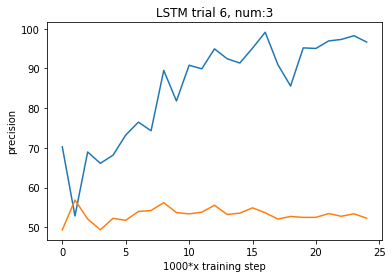

Epoch [6/150],step[1000] Loss:0.6142
precision of the model on thetrainingdata: 64.91227722167969%
precision of the model on thevalidationdata: 50.782718658447266%
Epoch [12/150],step[2000] Loss:0.5695
precision of the model on thetrainingdata: 68.33333587646484%
precision of the model on thevalidationdata: 50.79075241088867%
Epoch [18/150],step[3000] Loss:0.5612
precision of the model on thetrainingdata: 67.91044616699219%
precision of the model on thevalidationdata: 53.50624465942383%
Epoch [24/150],step[4000] Loss:0.5295
precision of the model on thetrainingdata: 72.5%
precision of the model on thevalidationdata: 51.85185241699219%
Epoch [30/150],step[5000] Loss:0.5005
precision of the model on thetrainingdata: 74.38016510009766%
precision of the model on thevalidationdata: 51.44194412231445%
Epoch [36/150],step[6000] Loss:0.4349
precision of the model on thetrainingdata: 75.20661163330078%
precision of the model on thevalidationdata: 51.744110107421875%
Epoch [42/150],step[7000] Lo

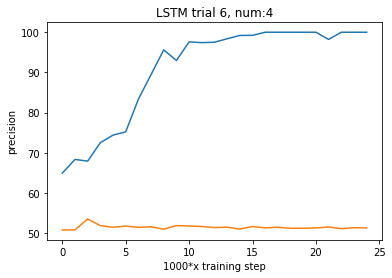

Epoch [6/150],step[1000] Loss:0.6290
precision of the model on thetrainingdata: 60.162601470947266%
precision of the model on thevalidationdata: 55.22894287109375%
Epoch [12/150],step[2000] Loss:0.6327
precision of the model on thetrainingdata: 71.60493469238281%
precision of the model on thevalidationdata: 53.83944320678711%
Epoch [18/150],step[3000] Loss:0.6441
precision of the model on thetrainingdata: 57.5%
precision of the model on thevalidationdata: 52.66831588745117%
Epoch [24/150],step[4000] Loss:0.5532
precision of the model on thetrainingdata: 74.13793182373047%
precision of the model on thevalidationdata: 54.66046905517578%
Epoch [30/150],step[5000] Loss:0.5860
precision of the model on thetrainingdata: 60.82474136352539%
precision of the model on thevalidationdata: 55.52790451049805%
Epoch [36/150],step[6000] Loss:0.5202
precision of the model on thetrainingdata: 75.89286041259766%
precision of the model on thevalidationdata: 54.03508758544922%
Epoch [42/150],step[7000] Los

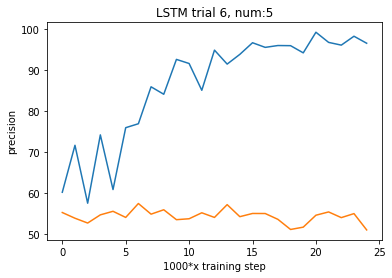

Epoch [6/150],step[1000] Loss:0.6695
precision of the model on thetrainingdata: 55.73770523071289%
precision of the model on thevalidationdata: 51.60103225708008%
Epoch [12/150],step[2000] Loss:0.6079
precision of the model on thetrainingdata: 62.96296310424805%
precision of the model on thevalidationdata: 49.60366439819336%
Epoch [18/150],step[3000] Loss:0.6153
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 47.53000259399414%
Epoch [24/150],step[4000] Loss:0.5902
precision of the model on thetrainingdata: 64.44444274902344%
precision of the model on thevalidationdata: 48.260868072509766%
Epoch [30/150],step[5000] Loss:0.5533
precision of the model on thetrainingdata: 67.24137878417969%
precision of the model on thevalidationdata: 49.17558670043945%
Epoch [36/150],step[6000] Loss:0.5456
precision of the model on thetrainingdata: 74.5614013671875%
precision of the model on thevalidationdata: 49.90496826171875%
Epoch [42/150],st

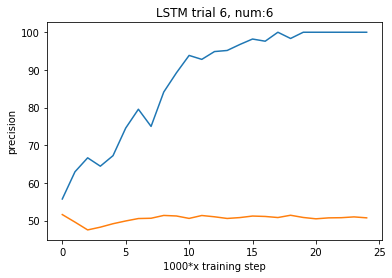

Epoch [6/150],step[1000] Loss:0.6277
precision of the model on thetrainingdata: 58.26771545410156%
precision of the model on thevalidationdata: 52.42744827270508%
Epoch [12/150],step[2000] Loss:0.6823
precision of the model on thetrainingdata: 60.377357482910156%
precision of the model on thevalidationdata: 51.94905471801758%
Epoch [18/150],step[3000] Loss:0.5887
precision of the model on thetrainingdata: 68.75%
precision of the model on thevalidationdata: 52.3588752746582%
Epoch [24/150],step[4000] Loss:0.5759
precision of the model on thetrainingdata: 76.19047546386719%
precision of the model on thevalidationdata: 57.96690368652344%
Epoch [30/150],step[5000] Loss:0.5841
precision of the model on thetrainingdata: 62.121212005615234%
precision of the model on thevalidationdata: 58.87662887573242%
Epoch [36/150],step[6000] Loss:0.5599
precision of the model on thetrainingdata: 71.69811248779297%
precision of the model on thevalidationdata: 57.74038314819336%
Epoch [42/150],step[7000] Lo

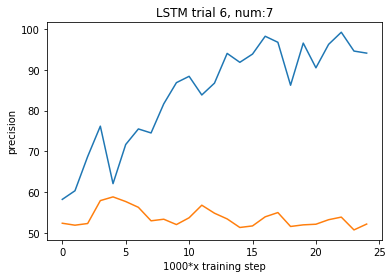

Epoch [6/150],step[1000] Loss:0.5777
precision of the model on thetrainingdata: 62.931034088134766%
precision of the model on thevalidationdata: 50.07372283935547%
Epoch [12/150],step[2000] Loss:0.5783
precision of the model on thetrainingdata: 60.31745910644531%
precision of the model on thevalidationdata: 47.1553840637207%
Epoch [18/150],step[3000] Loss:0.5527
precision of the model on thetrainingdata: 63.559322357177734%
precision of the model on thevalidationdata: 46.35730743408203%
Epoch [24/150],step[4000] Loss:0.5386
precision of the model on thetrainingdata: 73.91304016113281%
precision of the model on thevalidationdata: 47.65409469604492%
Epoch [30/150],step[5000] Loss:0.5077
precision of the model on thetrainingdata: 74.79674530029297%
precision of the model on thevalidationdata: 48.5011100769043%
Epoch [36/150],step[6000] Loss:0.4587
precision of the model on thetrainingdata: 69.918701171875%
precision of the model on thevalidationdata: 48.382354736328125%
Epoch [42/150],ste

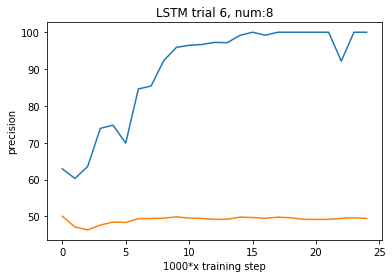

Epoch [6/150],step[1000] Loss:0.6099
precision of the model on thetrainingdata: 68.18181610107422%
precision of the model on thevalidationdata: 52.308685302734375%
Epoch [12/150],step[2000] Loss:0.5715
precision of the model on thetrainingdata: 67.5%
precision of the model on thevalidationdata: 52.380950927734375%
Epoch [18/150],step[3000] Loss:0.5841
precision of the model on thetrainingdata: 65.28925323486328%
precision of the model on thevalidationdata: 53.26370620727539%
Epoch [24/150],step[4000] Loss:0.5215
precision of the model on thetrainingdata: 71.92982482910156%
precision of the model on thevalidationdata: 53.41135025024414%
Epoch [30/150],step[5000] Loss:0.5334
precision of the model on thetrainingdata: 73.63636016845703%
precision of the model on thevalidationdata: 52.43655776977539%
Epoch [36/150],step[6000] Loss:0.4824
precision of the model on thetrainingdata: 71.21212005615234%
precision of the model on thevalidationdata: 52.250980377197266%
Epoch [42/150],step[7000] L

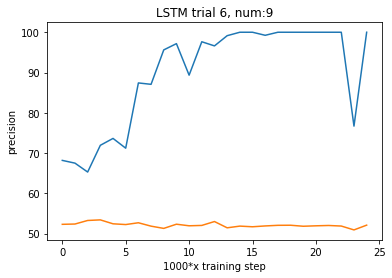

Epoch [6/150],step[1000] Loss:0.6633
precision of the model on thetrainingdata: 63.86554718017578%
precision of the model on thevalidationdata: 53.5185661315918%
Epoch [12/150],step[2000] Loss:0.5951
precision of the model on thetrainingdata: 68.42105102539062%
precision of the model on thevalidationdata: 52.917816162109375%
Epoch [18/150],step[3000] Loss:0.6062
precision of the model on thetrainingdata: 65.69342803955078%
precision of the model on thevalidationdata: 52.59397506713867%
Epoch [24/150],step[4000] Loss:0.5992
precision of the model on thetrainingdata: 66.01941680908203%
precision of the model on thevalidationdata: 52.80084991455078%
Epoch [30/150],step[5000] Loss:0.5102
precision of the model on thetrainingdata: 73.33333587646484%
precision of the model on thevalidationdata: 49.27801513671875%
Epoch [36/150],step[6000] Loss:0.4787
precision of the model on thetrainingdata: 78.4313735961914%
precision of the model on thevalidationdata: 51.791099548339844%
Epoch [42/150],st

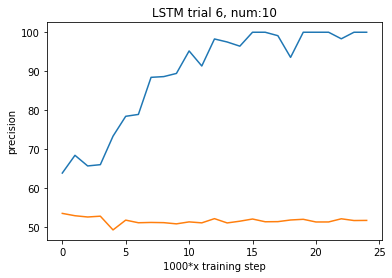

Epoch [6/150],step[1000] Loss:0.6196
precision of the model on thetrainingdata: 65.24822998046875%
precision of the model on thevalidationdata: 49.940921783447266%
Epoch [12/150],step[2000] Loss:0.6275
precision of the model on thetrainingdata: 58.260868072509766%
precision of the model on thevalidationdata: 52.407814025878906%
Epoch [18/150],step[3000] Loss:0.5934
precision of the model on thetrainingdata: 66.12903594970703%
precision of the model on thevalidationdata: 57.62681579589844%
Epoch [24/150],step[4000] Loss:0.5341
precision of the model on thetrainingdata: 67.71653747558594%
precision of the model on thevalidationdata: 53.339576721191406%
Epoch [30/150],step[5000] Loss:0.5349
precision of the model on thetrainingdata: 70.67668914794922%
precision of the model on thevalidationdata: 53.49127197265625%
Epoch [36/150],step[6000] Loss:0.4915
precision of the model on thetrainingdata: 69.17293548583984%
precision of the model on thevalidationdata: 53.85204315185547%
Epoch [42/150

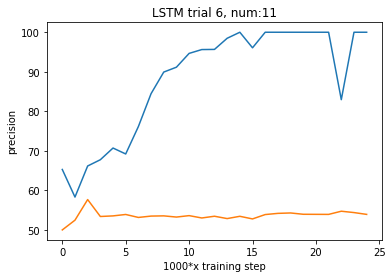

Epoch [6/150],step[1000] Loss:0.6147
precision of the model on thetrainingdata: 57.62711715698242%
precision of the model on thevalidationdata: 49.833702087402344%
Epoch [12/150],step[2000] Loss:0.5444
precision of the model on thetrainingdata: 73.03370666503906%
precision of the model on thevalidationdata: 51.057621002197266%
Epoch [18/150],step[3000] Loss:0.5583
precision of the model on thetrainingdata: 67.66917419433594%
precision of the model on thevalidationdata: 51.8223762512207%
Epoch [24/150],step[4000] Loss:0.5508
precision of the model on thetrainingdata: 70.94017028808594%
precision of the model on thevalidationdata: 54.4134521484375%
Epoch [30/150],step[5000] Loss:0.4748
precision of the model on thetrainingdata: 75.93984985351562%
precision of the model on thevalidationdata: 52.7003059387207%
Epoch [36/150],step[6000] Loss:0.4906
precision of the model on thetrainingdata: 73.72262573242188%
precision of the model on thevalidationdata: 54.53788375854492%
Epoch [42/150],ste

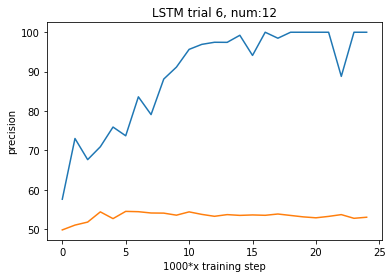

Epoch [6/150],step[1000] Loss:0.6732
precision of the model on thetrainingdata: 54.25531768798828%
precision of the model on thevalidationdata: 49.89043045043945%
Epoch [12/150],step[2000] Loss:0.5867
precision of the model on thetrainingdata: 64.42308044433594%
precision of the model on thevalidationdata: 50.7735595703125%
Epoch [18/150],step[3000] Loss:0.5629
precision of the model on thetrainingdata: 66.96428680419922%
precision of the model on thevalidationdata: 50.50802230834961%
Epoch [24/150],step[4000] Loss:0.5857
precision of the model on thetrainingdata: 65.2631607055664%
precision of the model on thevalidationdata: 53.18658447265625%
Epoch [30/150],step[5000] Loss:0.5487
precision of the model on thetrainingdata: 78.07017517089844%
precision of the model on thevalidationdata: 52.1954231262207%
Epoch [36/150],step[6000] Loss:0.5098
precision of the model on thetrainingdata: 71.0526351928711%
precision of the model on thevalidationdata: 53.96030807495117%
Epoch [42/150],step[7

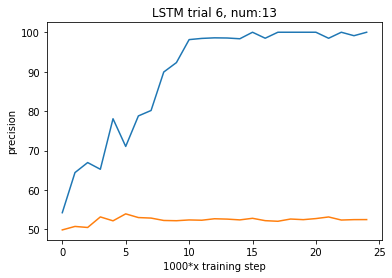

Epoch [6/150],step[1000] Loss:0.6604
precision of the model on thetrainingdata: 59.82143020629883%
precision of the model on thevalidationdata: 51.994300842285156%
Epoch [12/150],step[2000] Loss:0.5979
precision of the model on thetrainingdata: 58.33333206176758%
precision of the model on thevalidationdata: 55.171024322509766%
Epoch [18/150],step[3000] Loss:0.5960
precision of the model on thetrainingdata: 66.0%
precision of the model on thevalidationdata: 51.8557243347168%
Epoch [24/150],step[4000] Loss:0.6155
precision of the model on thetrainingdata: 71.96261596679688%
precision of the model on thevalidationdata: 55.211875915527344%
Epoch [30/150],step[5000] Loss:0.5574
precision of the model on thetrainingdata: 76.51515197753906%
precision of the model on thevalidationdata: 51.31052017211914%
Epoch [36/150],step[6000] Loss:0.5520
precision of the model on thetrainingdata: 64.8648681640625%
precision of the model on thevalidationdata: 50.598854064941406%
Epoch [42/150],step[7000] Lo

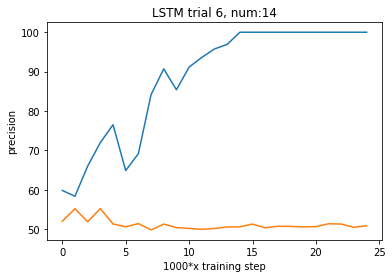

Epoch [6/150],step[1000] Loss:0.7012
precision of the model on thetrainingdata: 52.1008415222168%
precision of the model on thevalidationdata: 57.720008850097656%
Epoch [12/150],step[2000] Loss:0.6084
precision of the model on thetrainingdata: 65.41353607177734%
precision of the model on thevalidationdata: 50.318397521972656%
Epoch [18/150],step[3000] Loss:0.6054
precision of the model on thetrainingdata: 65.18518829345703%
precision of the model on thevalidationdata: 52.25880432128906%
Epoch [24/150],step[4000] Loss:0.5555
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 50.45952606201172%
Epoch [30/150],step[5000] Loss:0.5635
precision of the model on thetrainingdata: 66.94214630126953%
precision of the model on thevalidationdata: 50.90883255004883%
Epoch [36/150],step[6000] Loss:0.4922
precision of the model on thetrainingdata: 76.06837463378906%
precision of the model on thevalidationdata: 50.52175521850586%
Epoch [42/150],s

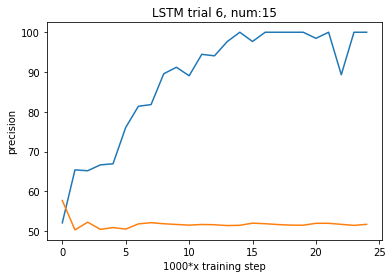

Epoch [6/150],step[1000] Loss:0.5902
precision of the model on thetrainingdata: 60.869564056396484%
precision of the model on thevalidationdata: 43.4986457824707%
Epoch [12/150],step[2000] Loss:0.5808
precision of the model on thetrainingdata: 61.48147964477539%
precision of the model on thevalidationdata: 47.3126220703125%
Epoch [18/150],step[3000] Loss:0.5974
precision of the model on thetrainingdata: 68.75%
precision of the model on thevalidationdata: 49.01071548461914%
Epoch [24/150],step[4000] Loss:0.5667
precision of the model on thetrainingdata: 68.49314880371094%
precision of the model on thevalidationdata: 49.55807113647461%
Epoch [30/150],step[5000] Loss:0.5019
precision of the model on thetrainingdata: 76.47058868408203%
precision of the model on thevalidationdata: 48.662471771240234%
Epoch [36/150],step[6000] Loss:0.4806
precision of the model on thetrainingdata: 79.3388442993164%
precision of the model on thevalidationdata: 49.634910583496094%
Epoch [42/150],step[7000] Los

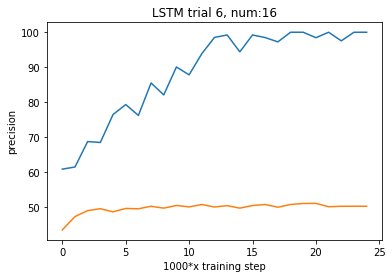

Epoch [6/150],step[1000] Loss:0.6451
precision of the model on thetrainingdata: 54.6875%
precision of the model on thevalidationdata: 53.14708709716797%
Epoch [12/150],step[2000] Loss:0.6072
precision of the model on thetrainingdata: 63.30275344848633%
precision of the model on thevalidationdata: 53.11004638671875%
Epoch [18/150],step[3000] Loss:0.5870
precision of the model on thetrainingdata: 61.2068977355957%
precision of the model on thevalidationdata: 51.97309494018555%
Epoch [24/150],step[4000] Loss:0.5545
precision of the model on thetrainingdata: 68.45637512207031%
precision of the model on thevalidationdata: 51.48673629760742%
Epoch [30/150],step[5000] Loss:0.5652
precision of the model on thetrainingdata: 68.29268646240234%
precision of the model on thevalidationdata: 52.422481536865234%
Epoch [36/150],step[6000] Loss:0.3781
precision of the model on thetrainingdata: 84.03361511230469%
precision of the model on thevalidationdata: 52.099266052246094%
Epoch [42/150],step[7000] 

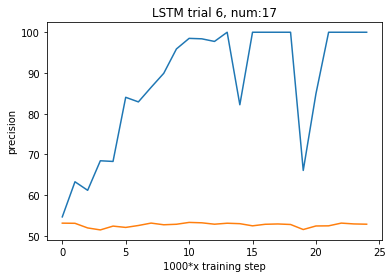

Epoch [6/150],step[1000] Loss:0.6577
precision of the model on thetrainingdata: 60.0%
precision of the model on thevalidationdata: 54.8435173034668%
Epoch [12/150],step[2000] Loss:0.5928
precision of the model on thetrainingdata: 68.0851058959961%
precision of the model on thevalidationdata: 55.92240905761719%
Epoch [18/150],step[3000] Loss:0.6127
precision of the model on thetrainingdata: 66.38655090332031%
precision of the model on thevalidationdata: 52.80976104736328%
Epoch [24/150],step[4000] Loss:0.5566
precision of the model on thetrainingdata: 66.40625%
precision of the model on thevalidationdata: 51.06801986694336%
Epoch [30/150],step[5000] Loss:0.5387
precision of the model on thetrainingdata: 73.84615325927734%
precision of the model on thevalidationdata: 51.78403854370117%
Epoch [36/150],step[6000] Loss:0.4704
precision of the model on thetrainingdata: 72.09302520751953%
precision of the model on thevalidationdata: 51.60886001586914%
Epoch [42/150],step[7000] Loss:0.3561
pre

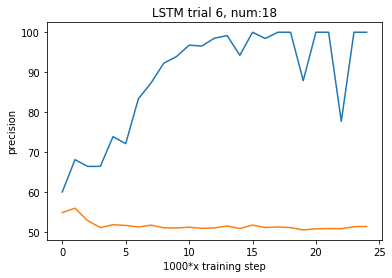

Epoch [6/150],step[1000] Loss:0.6809
precision of the model on thetrainingdata: 52.84552764892578%
precision of the model on thevalidationdata: 56.297157287597656%
Epoch [12/150],step[2000] Loss:0.6273
precision of the model on thetrainingdata: 63.157894134521484%
precision of the model on thevalidationdata: 50.535526275634766%
Epoch [18/150],step[3000] Loss:0.6220
precision of the model on thetrainingdata: 61.86440658569336%
precision of the model on thevalidationdata: 50.951778411865234%
Epoch [24/150],step[4000] Loss:0.6015
precision of the model on thetrainingdata: 54.31034469604492%
precision of the model on thevalidationdata: 51.08850860595703%
Epoch [30/150],step[5000] Loss:0.5589
precision of the model on thetrainingdata: 61.403507232666016%
precision of the model on thevalidationdata: 51.32465744018555%
Epoch [36/150],step[6000] Loss:0.5203
precision of the model on thetrainingdata: 77.34375%
precision of the model on thevalidationdata: 50.928550720214844%
Epoch [42/150],step[

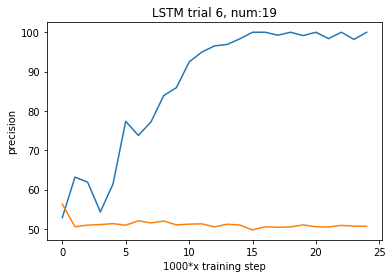

In [99]:
#trial 6
rand_select2=[]
max_precision2=[]
for i in range(20):
    factor=np.random.randint(42, size=10)
    rand_select2.append(factor)
    train_temp=train_data[:,:,factor]
    valid_temp=valid_data[:,:,factor]
    train=GetLoader(train_temp,train_label)
    valid=GetLoader(valid_temp,valid_label)
    
    #Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    input_size = 10  # 输入数据的维度
    hidden_size = 64  # 隐藏层的size
    num_layers =  3 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 150
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
    valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)
    
    lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
    
    max_precision2.append(max(valid_precision))
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("LSTM trial 6, num:"+str(i))
    plt.xlabel("1000*x training step")
    plt.ylabel("precision")
    plt.show()